In [1]:
import pygsti
from scipy.linalg import expm
import numpy as np
from pygsti.tools import unitary_to_superop
from pygsti.modelpacks import smq1Q_XYZI
from matplotlib import pyplot as plt
from pygsti.circuits import Circuit
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ
from tqdm import tqdm
from importlib import reload
import kalman_rpe_v2 as _krpe
import kalman_filters as _filters

In [2]:
reload(_krpe)
reload(_filters)

<module 'kalman_filters' from '/home/jpmarceaux/VSProjects/KalmanRPE/kalman_filters.py'>

In [3]:
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints, SimplexSigmaPoints, JulierSigmaPoints
from filterpy.kalman import unscented_transform
from copy import deepcopy
from numpy import dot

def prob_vec_to_signal(prob_vector):
    return (1-2*prob_vector[0]) + 1j*(1-2*prob_vector[1])

def format_observation(prob_vector, data_format="cartesian"):
    if data_format == "polar":
        signal = prob_vec_to_signal(prob_vector)
        return np.array([np.abs(signal), np.angle(signal)])
    elif data_format == "cartesian":
        return prob_vector

class Unitary_UKF_1Param(UnscentedKalmanFilter):
    def __init__(self, x, P, num_circs, save_history=False, dt=1, hx=None, fx=None, points=None):
        num_params = len(x)
        self.dt=1
        # self.points = JulierSigmaPoints(num_params, kappa=0)
        self.points = MerweScaledSigmaPoints(num_params, alpha=1e-3, beta=2, kappa=0)
        super().__init__(num_params, num_circs, dt=1, hx=self.hx, fx=self.fx, points=self.points)
        self.x = x
        self.P = P
        
        
        if save_history:
            self.xhistory = [x.copy()]
            self.Phistory = [P.copy()]
            self.store_history = True
        
        #self.points = SimplexSigmaPoints(num_params, alpha=1)
        
    def fx(self, x, dt, u=None):
        if u is None:
            u = np.zeros(len(x))
        return x + u

    def hx(self, x, circ_defs, data_format="cartesian"):
        pvec = _krpe.rpe_probabilities(x, circ_defs)
        return format_observation(pvec, data_format)

    def check_consistency_at_d(self, d):
        """Check that the experiment design at depth d is consistent for the sigma points."""
        pass
        
    def compute_process_sigmas(self, dt, fx=None, **fx_args):
        """
        computes the values of sigmas_f. Normally a user would not call
        this, but it is useful if you need to call update more than once
        between calls to predict (to update for multiple simultaneous
        measurements), so the sigmas correctly reflect the updated state
        x, P.
        """

        if fx is None:
            fx = self.fx
        # calculate sigma points for given mean and covariance
        sigmas = self.points_fn.sigma_points(self.x, self.P)

        for i, s in enumerate(sigmas):
            self.sigmas_f[i] = fx(s, dt, **fx_args)


    def update(self, count_dict, circ_defs, UT=None, hx=None, data_format="cartesian", debug=False):
        """
        Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.

        update one generation at a time

        Parameters
        ----------

        observation: emperical distribution

        d: int, depth of the circuit

        num_shots: int, number of shots per circuit

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work - you can use x_mean_fn and z_mean_fn to alter the behavior
            of the unscented transform.

        hx : callable h(x, **hx_args), optional
            Measurement function. If not provided, the default
            function passed in during construction will be used.

        **hx_args : keyword argument
            arguments to be passed into h(x) after x -> h(x, **hx_args)
        """


        if hx is None:
            hx = self.hx

        if UT is None:
            UT = unscented_transform

        # elif isscalar(R):
        #     R = eye(self._dim_z) * R
        cos_counts = count_dict[circ_defs[0]]
        sin_counts = count_dict[circ_defs[1]]
        num_counts = cos_counts[0] + cos_counts[1]
        num_sin_counts = sin_counts[0] + sin_counts[1]
        assert num_counts == num_sin_counts, "Number of counts for cos and sin circuits must be equal."
        cos_prob = cos_counts[0]/num_counts
        sin_prob = sin_counts[0]/num_counts
        
        z = format_observation(np.array([cos_prob, sin_prob]), data_format)
        counts = np.array([cos_counts[0], sin_counts[0]])
        cos_alpha = (counts[0] + 1)/(sum(counts) + 2)
        sin_alpha = (counts[1] + 1)/(sum(counts) + 2)
        #alpha_vec = (counts + np.ones(len(counts)))/(sum(counts) + len(counts)) # Uncomment for Dirichlet covar
        R = (1/num_counts)*np.diag( [cos_alpha*(1-cos_alpha), sin_alpha*(1-sin_alpha)] ) 
        #R = (0.25/num_counts)*np.eye(2)
        # pass prior sigmas through h(x) to get measurement sigmas
        # the shape of sigmas_h will vary if the shape of z varies, so
        # recreate each time
        sigmas_h = []
        for s in self.sigmas_f:
            sigmas_h.append(hx(s, circ_defs, data_format=data_format))
        self.sigmas_h = np.atleast_2d(sigmas_h)

        # mean and covariance of prediction passed through unscented transform
        zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
        self.SI = self.inv(self.S)
        if debug:
            print('z', z, 'zp', zp)

        # compute cross variance of the state and the measurements
        Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
        
        # DEBUG
        #print(self.sigmas_f, self.sigmas_h)
        if debug:
            print('Pxz', np.linalg.norm(Pxz), 'SI', np.linalg.norm(self.SI))

        self.K = dot(Pxz, self.SI)        # Kalman gain
        self.y = self.residual_z(z, zp)   # residual
        if debug:
            print(self.y, np.linalg.norm(self.K))

        x_new = self.x + dot(self.K, self.y)
        # phase unwrapping on x[2]
        # x_new[2] = np.unwrap([x_new[2]])
        # if np.linalg.norm(x_new - self.x) < tol:
        #     break
        # else:
        #     self.x = x_new
        #     self.compute_process_sigmas(self.dt, self.fx)
        #     #if i == max_iter - 1:
        #     #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
        self.x = x_new
        self.P = self.P - self.K@self.S@self.K.T

        # save measurement and posterior state
        self.x_post = self.x.copy()
        self.z = deepcopy(z)
        self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

        if self.store_history:
            self.xhistory.append(self.x)
            self.Phistory.append(self.P)


In [4]:
from matplotlib import cm

def plot_trajectories(trajectories, uncertainties=None, labels=None, colormap=None, start_idx=0):
    # plot parameter over time
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    if uncertainties is None:
        uncertainties = [None]*len(trajectories)
    if labels is None:
        labels = [None]*len(trajectories)
    if colormap is None:
        colormap = cm.get_cmap('viridis', 12)
    for idx, (traj, uncert, label) in enumerate(zip(trajectories, uncertainties, labels)):
        spacing = np.ceil(len(trajectories[0])/len(traj))
        traj_line = np.repeat(traj[:], spacing)
        ax.plot(np.arange(start_idx, len(traj_line), 1), traj_line[start_idx:], label=label, color=colormap(idx/len(trajectories)))
        if uncert is not None:
            uncert_line = np.repeat(uncert[:], spacing)
            ax.fill_between(np.arange(start_idx, len(traj_line), 1), traj_line[start_idx:] - uncert_line[start_idx:], traj_line[start_idx:] + uncert_line[start_idx:], alpha=0.2, color=colormap(idx/len(trajectories)))
    ax.set_xlabel("Time")
    ax.set_ylabel(f"Parameter")
    ax.legend()
    plt.show()

In [5]:
def step_xstate(xstate, q):
    # q is the varaiance 
    return xstate + np.random.normal(0, np.sqrt(q.flatten()))

def make_xstate_timseries(xstart, q, num_steps):
    xstates = [xstart]
    x = xstart.copy()
    for i in range(num_steps-1):
        x = step_xstate(x, q)
        xstates.append(x)
    return np.array(xstates)

In [6]:
def sample_circuit(xstate, circ_def):
    prob = _krpe.probability(xstate, *circ_def)
    prob = np.clip(prob, 0, 1)
    shot = np.random.binomial(1, prob)
    if shot:
        return np.array([1, 0])
    else:
        return np.array([0, 1])


def sample_circuits_from_trajectory(xtraj, starting_index, num_shot_per_circuit, circuit_list, raster=True):
    assert len(xtraj) >= starting_index + num_shot_per_circuit, "Trajectory is too short to sample circuits"
    circuit_samples = {circuit: np.zeros(2) for circuit in circuit_list}
    if raster:
        for i in range(num_shot_per_circuit):
            for circ in circuit_list:
                circuit_samples[circ] += sample_circuit(xtraj[starting_index + i], circ)
    else:
        for circ in circuit_list:
            for i in range(num_shot_per_circuit):
                circuit_samples[circ] += sample_circuit(xtraj[starting_index + i], circ)
    return circuit_samples


In [7]:
def process_rpe_data(cos_shots_at_depth, sin_shots_at_depth, depths):
    experiment = _rpeQ()
    for idx, d in enumerate(depths):
        experiment.process_cos(d, (int(cos_shots_at_depth[d][0]), int(cos_shots_at_depth[d][1])))
        experiment.process_sin(d, (int(sin_shots_at_depth[d][1]), int(sin_shots_at_depth[d][0])))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation

def sample_standard_experiment_batches(xtraj, starting_idx, num_shots_per_circuit, depths, num_batches, raster=True):
    assert len(xtraj) >= starting_idx + 2*num_shots_per_circuit*len(depths)*num_batches, "Trajectory is too short to sample circuits"
    batch_cos_shots = []
    batch_sin_shots = []
    running_idx = starting_idx
    if raster:
        for i in range(num_batches):
            cos_shots_at_depth = {}
            sin_shots_at_depth = {}
            for d in depths:
                cos_circ_def, sin_circ_def = _krpe.make_standard_experiment_at_depth(d)
                cos_shots_at_depth[d] = sample_circuit(xtraj[running_idx], cos_circ_def)
                sin_shots_at_depth[d] = sample_circuit(xtraj[running_idx+1], sin_circ_def)
                running_idx += 2
                if num_shots_per_circuit > 1:
                    for j in range(1, num_shots_per_circuit):
                        cos_shots_at_depth[d] += sample_circuit(xtraj[running_idx], cos_circ_def)
                        sin_shots_at_depth[d] += sample_circuit(xtraj[running_idx+1], sin_circ_def)
                        running_idx += 2
            batch_cos_shots.append(cos_shots_at_depth)
            batch_sin_shots.append(sin_shots_at_depth)
    elif batch: 
        raise NotImplementedError("Non-raster sampling not implemented")
    return batch_cos_shots, batch_sin_shots




In [8]:
def rectify_angle(angle):
    # set to be between -pi and pi
    return np.mod(angle + np.pi, 2*np.pi) - np.pi

In [9]:
def make_trig_estimate(cos_shots, sin_shots, depths, num_batches):
    all_processed_data = [process_rpe_data(cos_shots[i], sin_shots[i], depths) for i in range(num_batches)]
    rpe_estimates = np.array([data[0] for data in all_processed_data])
    trig_error_estimate = rectify_angle(rpe_estimates) - np.pi/2
    last_good_generations = np.array([data[1] for data in all_processed_data])
    return trig_error_estimate, last_good_generations

In [10]:
def make_kalman_forward_estimate(x0, P0, Q, cos_shots, sin_shots, depths, num_batches):
    ukf = Unitary_UKF_1Param(x0, P0, 2, save_history=True)
    ukf.Q = Q
    for batch in range(num_batches):
        for d in range(len(depths)):
            cos_counts = cos_shots[batch][depths[d]]
            sin_counts = sin_shots[batch][depths[d]]
            cos_circ_def, sin_circ_def = _krpe.make_standard_experiment_at_depth(depths[d])
            count_dict = {cos_circ_def: cos_counts, sin_circ_def: sin_counts}
            ukf.predict()
            ukf.update(count_dict, [cos_circ_def, sin_circ_def], data_format="cartesian")
    return ukf.xhistory[1:], ukf.Phistory[1:]

In [11]:
# smoothed estimate creation
def rts_smoother(Xs, Ps, F, Q):
    n, dim_x, _ = Xs.shape

    # smoother gain
    K = np.zeros((n,dim_x, dim_x))
    x, P, Pp = Xs.copy(), Ps.copy(), Ps.copy()

    for k in range(n-2,-1,-1):
        Pp[k] = F @ P[k] @ F.T + Q # predicted covariance

        K[k]  = P[k] @ F.T @ np.linalg.inv(Pp[k])
        x[k] += K[k] @ (x[k+1] - (F @ x[k]))     
        P[k] += K[k] @ (P[k+1] - Pp[k]) @ K[k].T
    return (x, P, K, Pp)



In [12]:
def bootstrapped_calculation_standard_rastered_experiment(xtraj, depths, num_shots_per_circuit, 
                                                          Q, 
                                                          num_bootstraps):
    all_trig_estimates = []
    all_forward_estimates = []
    all_smoothed_estimates = []
    all_forward_covars = []
    all_smoothed_covars = []
    for b in tqdm(range(num_bootstraps)):
        num_steps = len(xtraj)
        num_batches = num_steps/(2*num_shots_per_circuit*len(depths))
        assert num_batches.is_integer(), "Number of batches must be an integer"
        num_batches = int(num_batches)
        cos_shots, sin_shots = sample_standard_experiment_batches(xtraj_true, 0, num_shots_per_circuit, depths, num_batches, raster=True)

        # calculate the trigonometric error estimate
        trig_error_estimate, last_good_generations = make_trig_estimate(cos_shots, sin_shots, depths, num_batches)

        # calculate the forward and smoothed UKF estimates
        x0 = np.array([trig_error_estimate[0, -1]])
        P0 = np.array([[(2*np.pi/(np.sqrt(num_shots_per_circuit)*2**last_good_generations[-1]))**2]])
        x_forward, P_forward = make_kalman_forward_estimate(x0, P0, Q, cos_shots, sin_shots, depths, num_batches)
        x_forward = np.array(x_forward).reshape(-1, 1, 1)
        P_forward = np.array(P_forward)
        x_smoothed, P_smoothed, K, Pp = rts_smoother(x_forward, P_forward, np.eye(1), Q)

        all_trig_estimates.append(trig_error_estimate[:, -1])
        all_forward_estimates.append(x_forward)
        all_smoothed_estimates.append(x_smoothed)
        all_forward_covars.append(P_forward)
        all_smoothed_covars.append(P_smoothed)
    return np.array(all_trig_estimates), np.array(all_forward_estimates), np.array(all_smoothed_estimates), np.array(all_forward_covars), np.array(all_smoothed_covars)



In [90]:
xstate_initial = np.array([0.1])
Q_datagen = np.array([[1e-6]])
num_steps = 10000
oscillation = 0.00*np.sin(np.linspace(0, 2*np.pi*3, num_steps))
xtraj_true = make_xstate_timseries(xstate_initial, Q_datagen, num_steps) + oscillation.reshape(-1, 1)

/tmp/ipykernel_5249/2671365953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


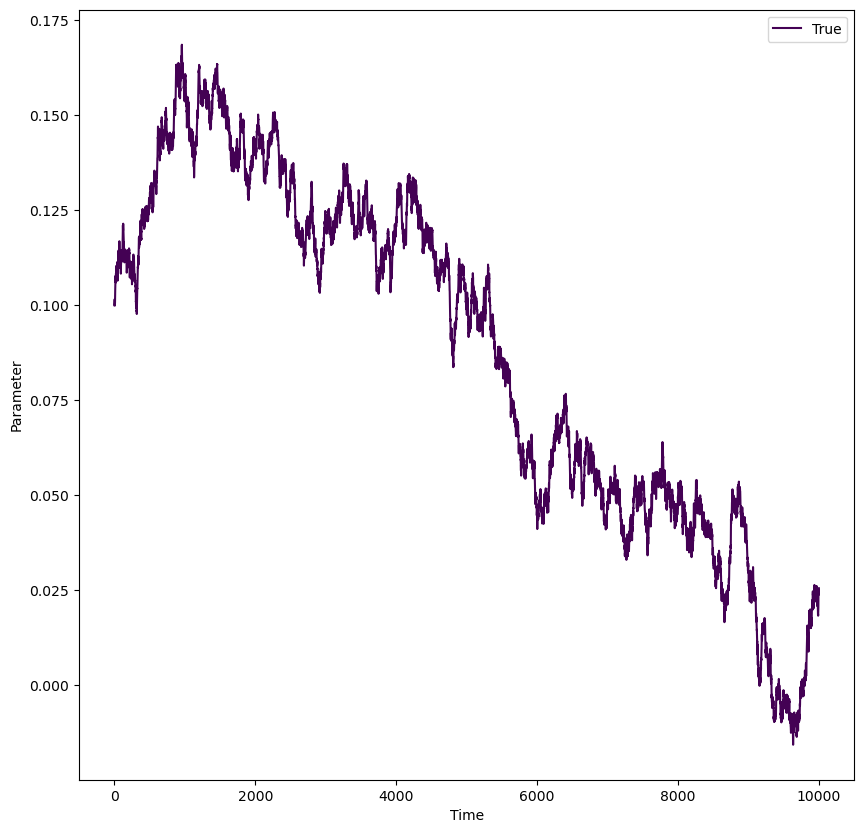

In [91]:
plot_trajectories([xtraj_true], labels=["True"], uncertainties=[None], start_idx=0)

In [108]:
num_shots_per_circuit = 10
depths = [2**i for i in range(5)]
Q = 2*num_shots_per_circuit*Q_datagen
num_bootstraps = 10

all_trig_estimates, all_forward_estimates, all_smoothed_estimates, all_forward_covars, all_smoothed_covars = bootstrapped_calculation_standard_rastered_experiment(xtraj_true, depths, num_shots_per_circuit, Q, num_bootstraps)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:56<00:00,  5.66s/it]


/tmp/ipykernel_5249/2671365953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


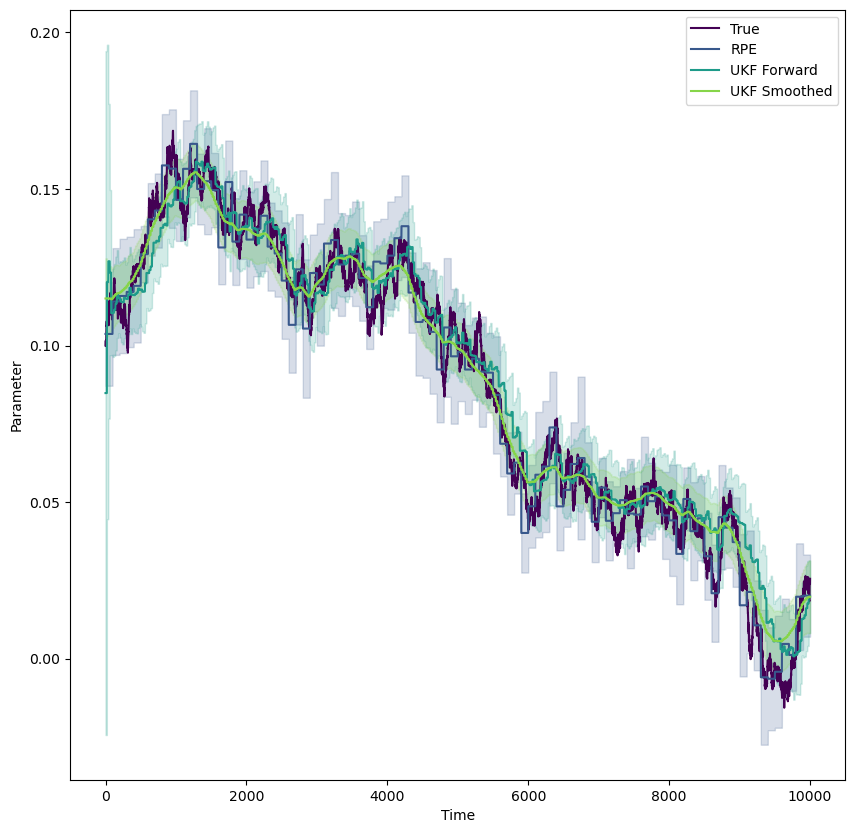

In [109]:
mean_bootstrap_trig_estimate = np.mean(all_trig_estimates, axis=0)
mean_bootstrap_forward_estimate = np.mean(all_forward_estimates, axis=0)
mean_bootstrap_smoothed_estimate = np.mean(all_smoothed_estimates, axis=0)

trig_bootsrapped_std = np.sqrt(np.mean(all_trig_estimates**2, axis=0) - mean_bootstrap_trig_estimate**2)
forward_bootstrap_std = np.sqrt(np.mean(all_forward_covars, axis=0))
smoothed_bootstrap_std = np.sqrt(np.mean(all_smoothed_covars, axis=0))
plot_trajectories([xtraj_true, mean_bootstrap_trig_estimate, mean_bootstrap_forward_estimate, mean_bootstrap_smoothed_estimate], labels=["True", "RPE", "UKF Forward", "UKF Smoothed"], uncertainties=[None, trig_bootsrapped_std, forward_bootstrap_std, smoothed_bootstrap_std], start_idx=0)

/tmp/ipykernel_5249/2671365953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


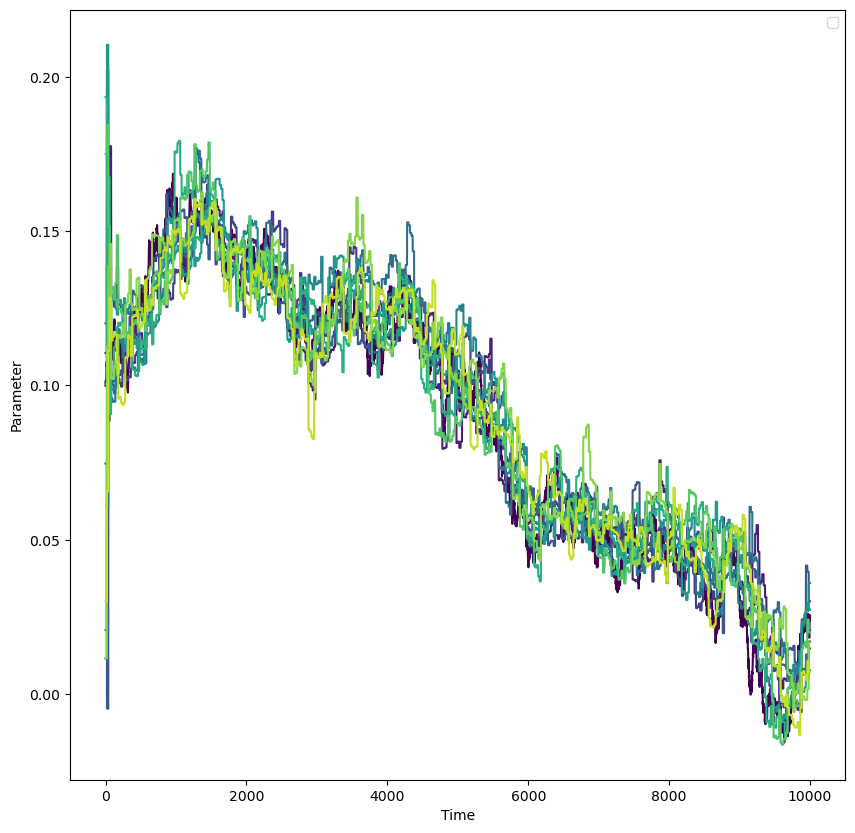

In [110]:
plot_trajectories([xtraj_true, *[f for f in all_forward_estimates]])

In [111]:
def pad_trajectory(length_xtrue, traj):
    spacing = length_xtrue/len(traj)
    assert spacing.is_integer(), "Trajectory lengths are not compatible"
    spacing = int(spacing)
    return np.repeat(traj, spacing)

def mse_in_traj(true_traj, estimate_traj, starting_idx=0):
    # padd the estimate trajectory if it is shorter
    if len(true_traj) > len(estimate_traj):
        estimate_traj = pad_trajectory(len(true_traj), estimate_traj)
    return np.mean((true_traj[starting_idx:] - estimate_traj[starting_idx:])**2)

def mse_in_bootstrap(true_traj, bootstrap_traj, starting_idx=0):
    return np.mean([mse_in_traj(true_traj, traj, starting_idx) for traj in bootstrap_traj])

In [112]:
mse_in_bootstrap(xtraj_true, all_trig_estimates)

0.004587927295584121

In [113]:
mse_in_bootstrap(xtraj_true, all_forward_estimates)

0.004155293912332402

In [114]:
mse_in_bootstrap(xtraj_true, all_smoothed_estimates)

0.004116704890659613

---

# Q-fitting

strategy is to make a bunch of different Kalman filters with different Qs, then fit the one that has the best likelihood

/tmp/ipykernel_5249/2671365953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


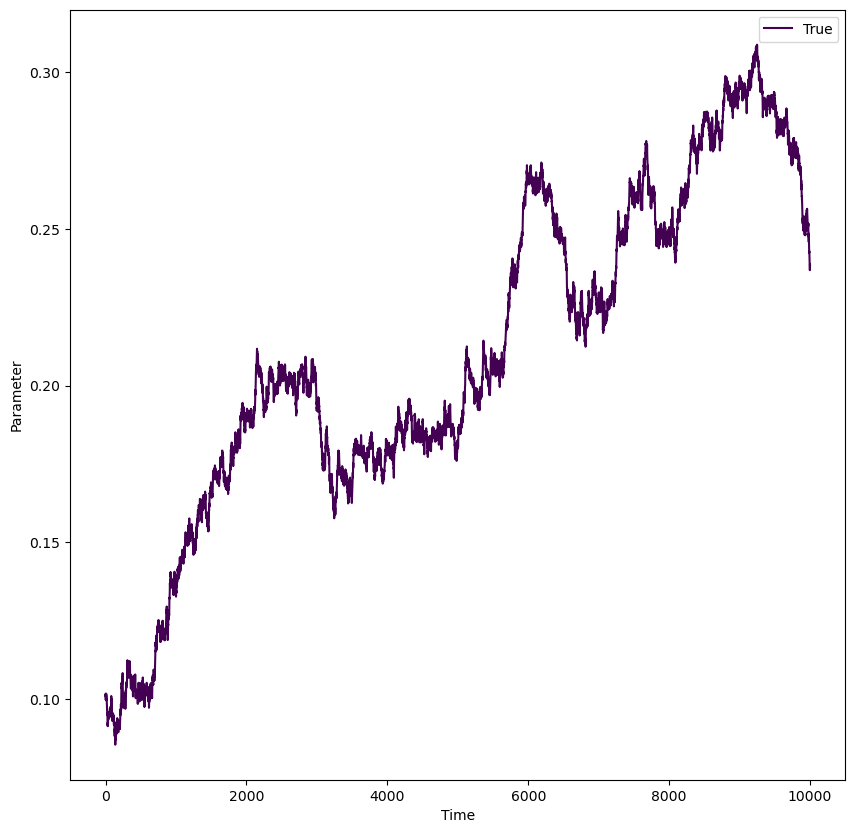

In [47]:
xstate_initial = np.array([0.1])
Q_datagen = np.array([[1e-6]])
num_steps = 10000
oscillation = 0.00*np.sin(np.linspace(0, 2*np.pi*4, num_steps))
xtraj_true = make_xstate_timseries(xstate_initial, Q_datagen, num_steps) + oscillation.reshape(-1, 1)
plot_trajectories([xtraj_true], labels=["True"], uncertainties=[None], start_idx=0)

In [88]:
num_shots_per_circuit = 1000
depths = [2**i for i in range(5)]
assert len(depths)*2*num_shots_per_circuit == num_steps

cos_shots_at_depth = {}
sin_shots_at_depth = {}
for d in depths:
    cos_circ_def, sin_circ_def = _krpe.make_standard_experiment_at_depth(d)
    cos_shots_at_depth[d] = sample_circuit(xtraj_true[0], cos_circ_def)
    sin_shots_at_depth[d] = sample_circuit(xtraj_true[1], sin_circ_def)
    if num_shots_per_circuit > 1:
        for i in range(1, num_shots_per_circuit):
            cos_shots_at_depth[d] += sample_circuit(xtraj_true[2*i], cos_circ_def)
            sin_shots_at_depth[d] += sample_circuit(xtraj_true[2*i+1], sin_circ_def)
            


In [49]:
x0 = np.array([0.0])
P0 = np.array([[1e-6]])

Qs = [np.array([[1e-6]])*10**i for i in range(5)]

forward_estimates_with_Qs = []
forward_covars_with_Qs = []
for Q in tqdm(Qs):
    x_forward, P_forward = make_kalman_forward_estimate(x0, P0, Q, cos_shots_at_depth, sin_shots_at_depth, depths, num_batches)
    forward_estimates_with_Qs.append(x_forward)
    forward_covars_with_Qs.append(P_forward)


100%|██████████| 5/5 [00:01<00:00,  3.77it/s]


In [50]:
def gaussian_log_likelihood(x, P):
    return -0.5*np.log(P) - x*(1/P)*x

def calculate_kalman_innovation_likelihood(cos_shots, sin_shots, kalman_estimates, kalman_covars):
    likelihoods = []

    itr = 0
    for cos_observatios, sin_observations in zip(cos_shots, sin_shots):
        depths = list(cos_observatios.keys())
        likelihood = 0
        for d in depths:
            cos_counts = cos_observatios[d]
            sin_counts = sin_observations[d]
            
            emperical_prob_vec = np.array([cos_counts[0]/(cos_counts[0] + cos_counts[1]), sin_counts[0]/(sin_counts[0] + sin_counts[1])])
            emperical_prob_vec = np.clip(emperical_prob_vec, 0, 1)
            
            cos_circ_def, sin_circ_def = _krpe.make_standard_experiment_at_depth(d)
            estimate_pred = _krpe.rpe_probabilities(kalman_estimates[itr], [cos_circ_def, sin_circ_def])
            estimate_pred = np.clip(estimate_pred, 0, 1)
            estimate_covar = kalman_covars[itr]
            likelihood += gaussian_log_likelihood(emperical_prob_vec - estimate_pred, estimate_covar)
            likelihoods.append(likelihood)
            itr += 1
    return sum(likelihoods)

        

/tmp/ipykernel_5249/2671365953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


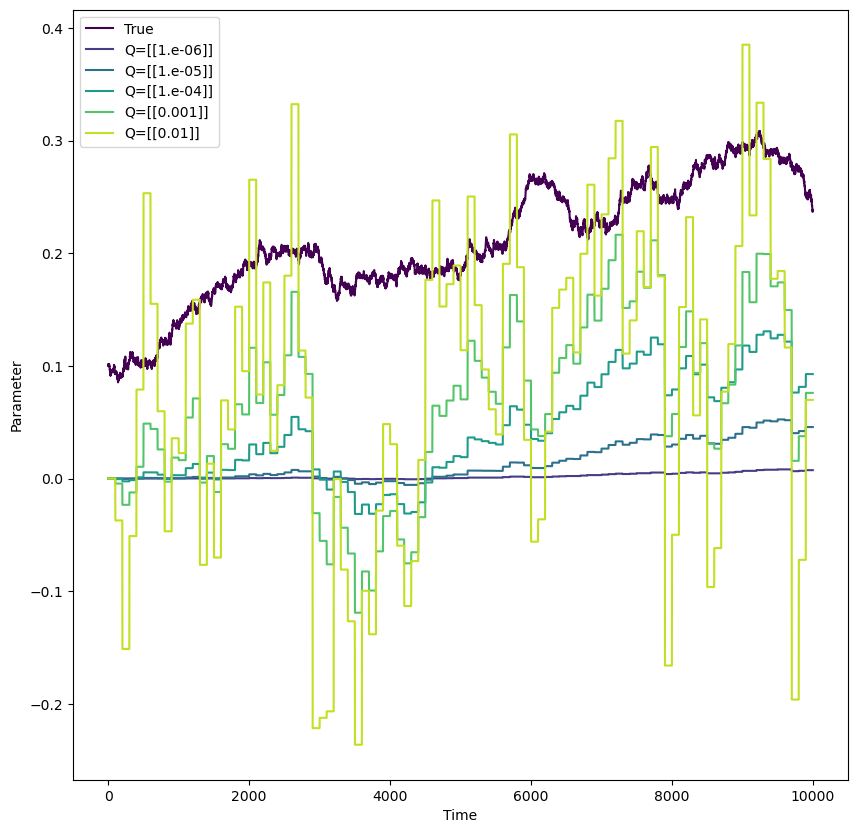

In [51]:
plot_trajectories([xtraj_true, *[f for f in forward_estimates_with_Qs]], labels=["True", *[f"Q={Q}" for Q in Qs]])

In [57]:
log_likelihoods = np.array([calculate_kalman_innovation_likelihood(cos_shots, sin_shots, forward_estimates_with_Qs[i], forward_covars_with_Qs[i]) for i in range(len(Qs))])
# display 
log_likelihoods

array([[[-1.17178899e+05, -1.26020277e+03]],

       [[-1.35339301e+04,  1.98405481e+02]],

       [[-1.51209085e+03,  2.86036199e+02]],

       [[-8.11980093e+01,  2.39677475e+02]],

       [[ 1.25637679e+02,  1.76429864e+02]]])

---

In [ ]:
depths = [2**i for i in range(10)]
num_shots_per_circuit = 50
num_batches = num_steps/(2*num_shots_per_circuit*len(depths))
assert num_batches.is_integer(), "Number of batches must be an integer"
num_batches = int(num_batches)
cos_shots, sin_shots = sample_standard_experiment_batches(xtraj_true, 0, num_shots_per_circuit, depths, num_batches, raster=True)

In [ ]:
trig_error_estimate, last_good_generations = make_trig_estimate(cos_shots, sin_shots, depths, num_batches)

In [ ]:
Q = 2*num_shots_per_circuit*Q_datagen*10
P = np.array([[(2*np.pi/(np.sqrt(num_shots_per_circuit)*2**last_good_generations[-1]))**2]])
x0 = np.array([trig_error_estimate[0, -1]])
x_forward, P_forward = make_kalman_forward_estimate(x0, P, Q, cos_shots, sin_shots, depths, num_batches)

x_forward = np.array(x_forward).reshape(-1, 1, 1)
P_forward = np.array(P_forward)

x_smoothed, P_smoothed, K, Pp = rts_smoother(x_forward, P_forward, np.eye(1), Q)

/tmp/ipykernel_5021/2671365953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


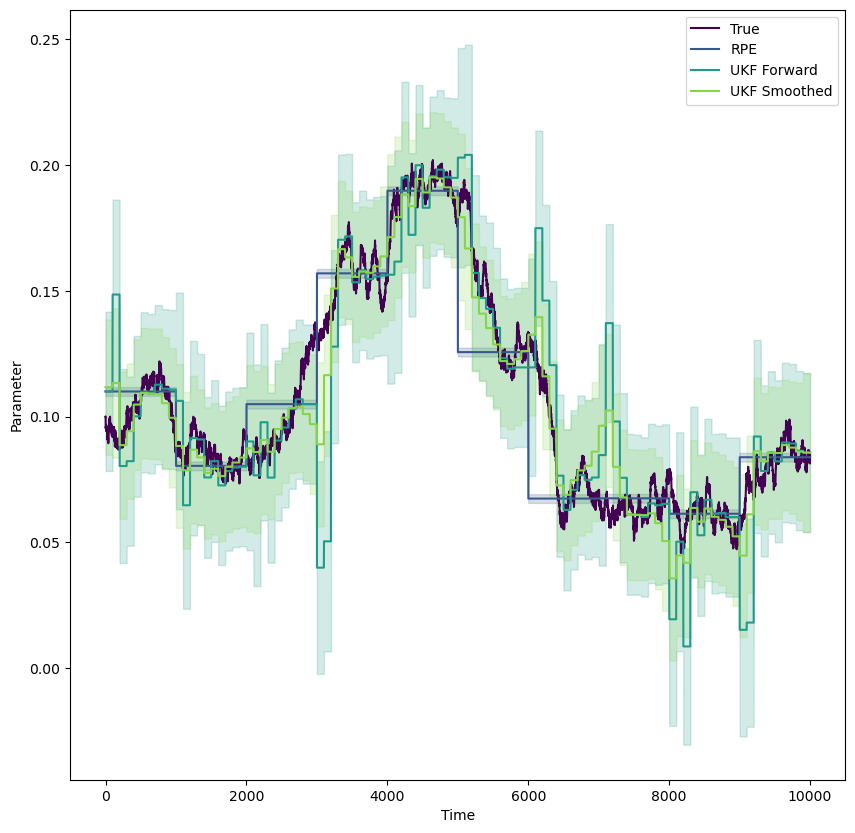

In [ ]:
trig_error_bounds = 2*np.pi/(np.sqrt(num_shots_per_circuit)*2**last_good_generations[-1]) * np.ones(len(trig_error_estimate[:, -1]))
plot_trajectories([xtraj_true, trig_error_estimate[:, -1], x_forward, x_smoothed], labels=["True", "RPE", "UKF Forward", "UKF Smoothed"], uncertainties=[None, trig_error_bounds, np.sqrt(P_forward), np.sqrt(P_smoothed)], start_idx=0)

In [ ]:
def sample_and_make_trig_estimate(xtraj, starting_idx, num_shots_per_circuit, depths, raster=True):
    assert len(xtraj) >= starting_idx + 2*num_shots_per_circuit*len(depths), "Trajectory is too short to sample circuits"
    cos_shots_at_depth = {}
    sin_shots_at_depth = {}
    running_idx = starting_idx
    for d in depths:
        cos_circ_def, sin_circ_def = _krpe.make_standard_experiment_at_depth(d)
        all_shots_at_depth = sample_circuits_from_trajectory(xtraj, running_idx, num_shots_per_circuit, [cos_circ_def, sin_circ_def], raster=raster)
        cos_shots_at_depth[d] = all_shots_at_depth[cos_circ_def]
        sin_shots_at_depth[d] = all_shots_at_depth[sin_circ_def]
        running_idx += 2*num_shots_per_circuit
    return process_rpe_data(cos_shots_at_depth, sin_shots_at_depth, depths)

In [ ]:
sample_standard_experiment_batches(xtraj_true, 10, 100, [1], 10, raster=True)

([{1: array([52, 48])},
  {1: array([50, 50])},
  {1: array([44, 56])},
  {1: array([42, 58])},
  {1: array([44, 56])},
  {1: array([45, 55])},
  {1: array([42, 58])},
  {1: array([43, 57])},
  {1: array([38, 62])},
  {1: array([55, 45])}],
 [{1: array([  0, 100])},
  {1: array([  0, 100])},
  {1: array([  0, 100])},
  {1: array([  0, 100])},
  {1: array([ 2, 98])},
  {1: array([  0, 100])},
  {1: array([  0, 100])},
  {1: array([ 1, 99])},
  {1: array([  0, 100])},
  {1: array([  0, 100])}])

In [ ]:
depths = [2**i for i in range(14)]
sample_and_make_trig_estimate(xtraj_true, 0, num_shots_per_circuit=100, depths=depths)

(array([1.80634131, 1.69088183, 1.69757095, 1.67102009, 1.6715207 ,
        1.65448211, 1.66588679, 1.65783449, 1.64914714, 1.65031   ,
        1.65220537, 1.65260042, 1.65316924, 1.65298033]),
 7)

In [ ]:
2**9

512

In [ ]:
def make_trig_estimate_batches(xtraj, num_shots_per_circuit, depths, raster=True):
    num_batches = len(xtraj)//(2*num_shots_per_circuit*len(depths))
    estimates = []
    last_good_gens = []
    for i in tqdm(range(num_batches)):
        e, g = sample_and_make_trig_estimate(xtraj, i*2*num_shots_per_circuit*len(depths), num_shots_per_circuit, depths, raster=raster)
        estimates.append(e)
        last_good_gens.append(g)
    return np.array(estimates), np.array(last_good_gens)

In [ ]:
estimates, last_good_gens = make_trig_estimate_batches(xtraj_true, num_shots_per_circuit=100, depths=depths, raster=True)

  0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt: 

/tmp/ipykernel_4298/2671365953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


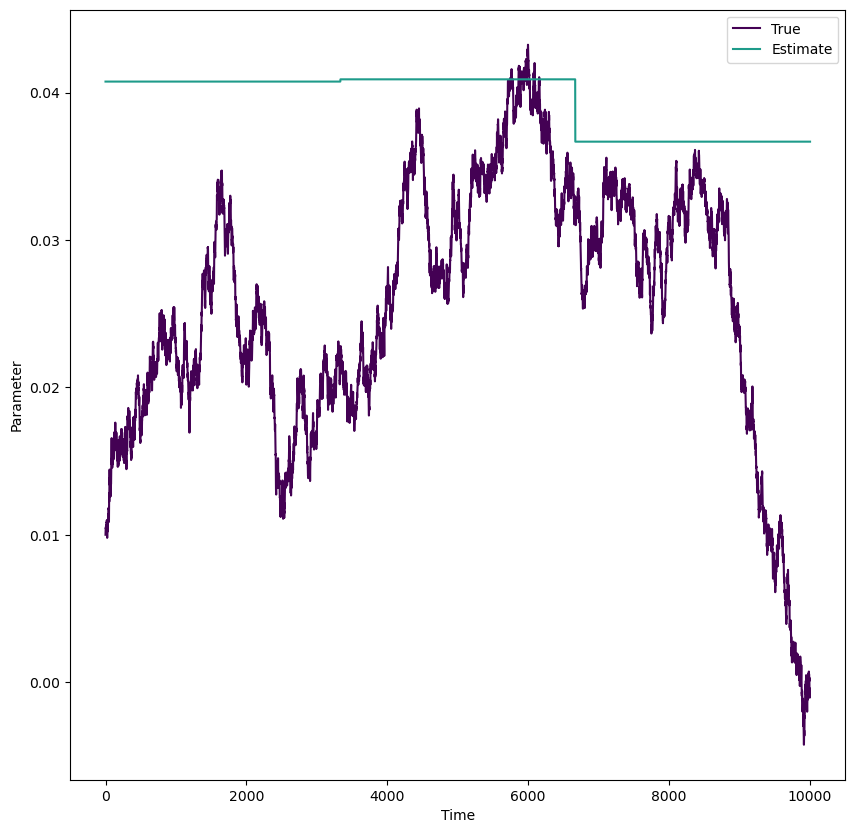

In [ ]:
plot_trajectories([xtraj_true, estimates[:, -1]-np.pi/2], labels=["True", "Estimate"], uncertainties=[None, None], start_idx=0)

In [ ]:
def depth_function(idx, p, q):
    return 256

In [ ]:
# make ukf
xstate_initial = np.array([0.01])

num_shots_per_circuit = 10
Q = np.array([[1e-9]])*num_shots_per_circuit*2
P_initial = Q

num_batches = len(xtraj_true)//(2*num_shots_per_circuit)

ukf = Unitary_UKF_1Param(xstate_initial, P_initial, len(depths), save_history=True)
ukf.Q = Q

depth_history = []
for i in tqdm(range(num_batches)):
    d = depth_function(i, ukf.P, Q)
    depths.append(d)
    circ_defs = _krpe.make_standard_experiment_at_depth(d)
    count_dict = sample_circuits_from_trajectory(xtraj_true, i*2*num_shots_per_circuit, num_shots_per_circuit, circ_defs, raster=True)
    ukf.predict()
    ukf.update(count_dict, circ_defs)


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:05<00:00, 85.18it/s]


/tmp/ipykernel_4298/2671365953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', 12)


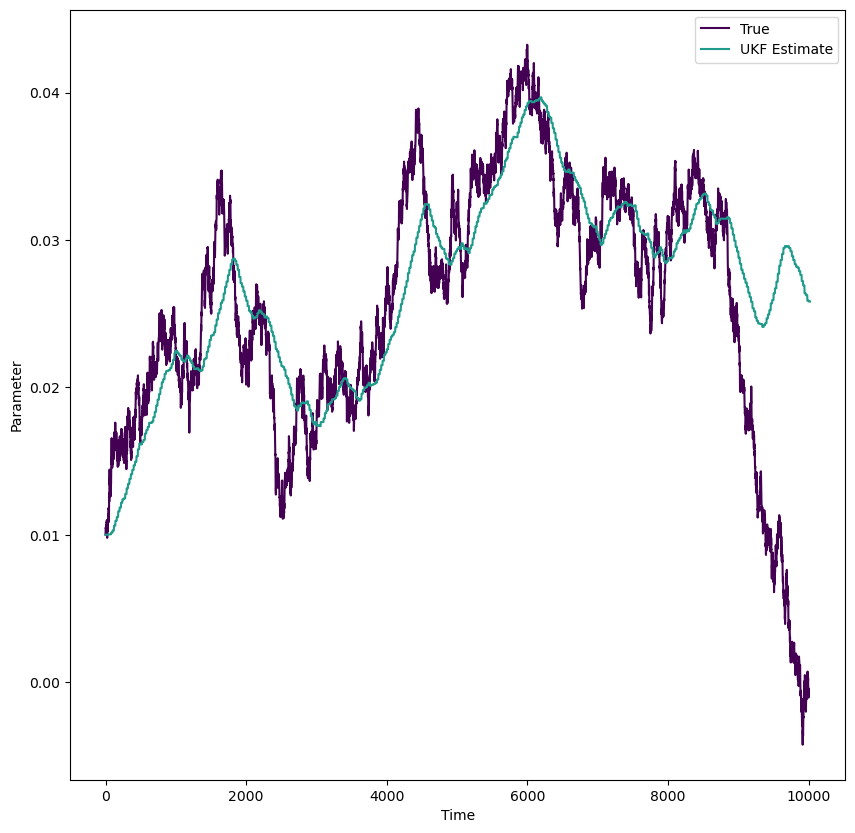

In [ ]:
plot_trajectories([xtraj_true, ukf.xhistory], labels=["True", "UKF Estimate"], uncertainties=[None, None], start_idx=0)